In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [3]:
from lib import fca_interp as fcai

In [4]:
from lib.utils_ import powerset

In [5]:
from importlib import reload

In [6]:
from datetime import datetime
def get_curtime_str():
    return datetime.now().strftime('%d.%m.%y_%H:%M')

# Create the model
Following https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

# Настройка Pattern Structures

In [7]:
from keras.datasets import mnist

Using TensorFlow backend.


In [8]:
img_rows, img_cols = 28, 28

In [9]:
preds_test = np.load('mnist_test_preds.numpy', allow_pickle=True)

In [10]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 34s 3us/step


In [20]:
len(x_test), len(x_train)

(10000, 60000)

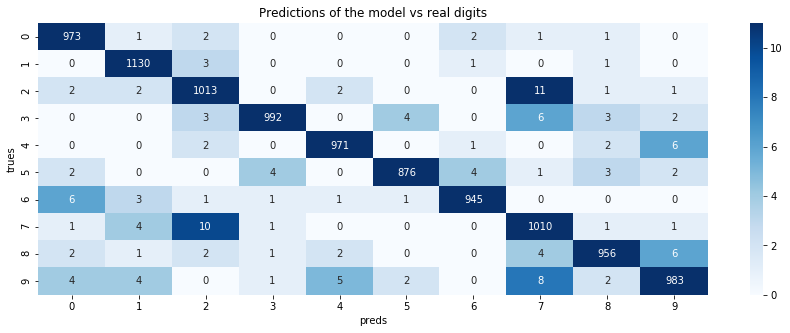

In [12]:
cds = pd.DataFrame()
cds['trues'] = y_test
cds['preds'] = preds_test
cds['cnt'] = 1
cds = cds.astype(int)
cds.head()

plt.figure(figsize=(15,5))
cds = cds.pivot_table(index='trues',columns='preds', aggfunc='sum', values='cnt').fillna(0).astype(int)
sns.heatmap(cds, annot=True, cmap='Blues', fmt='d', vmax=(cds-np.diag(cds)*np.eye(len(cds))).max().max())
plt.title('Predictions of the model vs real digits')
plt.show()

In [13]:
(cds-np.diag(cds)*np.eye(len(cds))).sum().sort_values(ascending=False)

preds
7    31.0
2    23.0
9    18.0
0    17.0
1    15.0
8    14.0
4    10.0
6     8.0
3     8.0
5     7.0
dtype: float64

In [14]:
x_test_flatten = x_test.reshape((x_test.shape[0], img_rows*img_cols))

In [15]:
x_test_flatten = x_test_flatten[:1000]
y_test = y_test[:1000]
preds_test = preds_test[:1000]

In [16]:
ds = pd.DataFrame(x_test_flatten)
ds = ds.astype(int)
print(ds.shape)
ds.columns = [f"({y},{x})" for y in range(img_rows) for x in range(img_cols)]
ds.index = ds.index.astype(str)
ds.head()

(1000, 784)


,"(0,0)","(0,1)","(0,2)","(0,3)","(0,4)","(0,5)","(0,6)","(0,7)","(0,8)","(0,9)",...,"(27,18)","(27,19)","(27,20)","(27,21)","(27,22)","(27,23)","(27,24)","(27,25)","(27,26)","(27,27)"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
mvcntx_full = fcai.MultiValuedContext(ds, cat_attrs=[], y_true=y_test)

In [24]:
mvcntx_dict = {}

In [19]:
def compare_concept_image(int_, mvcntx, mvcntx_full, ds):
    ext_ = mvcntx.get_extent(int_)
    ext_full = mvcntx_full.get_extent(int_)
    strongness = len(ext_)/len(ext_full) if len(ext_)>0 else 0
    
    plt.subplot(121)
    plt.imshow(np.array([np.mean(v) for k,v in int_.items()]).reshape((img_rows, img_cols)), cmap='Greys')
    plt.title('Image created from intent')

    plt.subplot(122)
    plt.imshow(ds.loc[ext_full].mean(0).values.reshape((28,28)), cmap='Greys')
    plt.title('Mean image of extent')


    plt.subplots_adjust(top=0.99)
    plt.suptitle(f'Strongness: {len(ext_)/len(ext_full) if len(ext_)>0 else 0}')
    plt.tight_layout()

    plt.show()    

In [44]:
%%time
fm = fcai.FormalManager(mvcntx_full)
fm.construct_concepts(
    algo='RandomForest',
    rf_params={'n_estimators':100, 'max_depth':None, 'min_samples_leaf':30, 'random_state':42})


CPU times: user 30min 15s, sys: 17.7 s, total: 30min 33s
Wall time: 29min 57s


In [42]:
fm.construct_lattice(use_tqdm=True)

Exception ignored in: <function tqdm.__del__ at 0x7fdf1e4074d0>
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1065, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
fm.calc_stability_approx()

In [ ]:
fig = fm.get_plotly_fig(color_by='y_mean_true')
fig

In [ ]:
fm.save_concepts_json(RESULTS_DIR+f'/mnist_withrf_{get_curtime_str}.json')